# House Price - Adcanced Regression Tchniques
![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

# Load the House Price Data set from github

Team members: Siyu Jian, Hua Meng, Nan Jiang and Joy Wang


In [38]:
! wget -nc https://raw.githubusercontent.com/Jiansiyu/Classes/master/SYS6018_data%20mining/homework/homeworkproj/homework8/house-prices-advanced-regression-techniques/test.csv
! wget -nc https://raw.githubusercontent.com/Jiansiyu/Classes/master/SYS6018_data%20mining/homework/homeworkproj/homework8/house-prices-advanced-regression-techniques/train.csv
! wget -nc https://raw.githubusercontent.com/Jiansiyu/Classes/master/SYS6018_data%20mining/homework/homeworkproj/homework8/house-prices-advanced-regression-techniques/sample_submission.csv

from IPython.display import clear_output
clear_output(wait=True)

File ‘test.csv’ already there; not retrieving.

File ‘train.csv’ already there; not retrieving.

File ‘sample_submission.csv’ already there; not retrieving.



# Load the dataset to the 

In [39]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,LassoCV
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import  skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
%matplotlib inline

In [30]:
train = pd.read_csv("./train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Clean The Dataset

## data clean process

In [50]:
typoTable = {"Exterior2nd":[{"Brk Cmn":"BrkComm"},{"Wd Shng":"Wd Sdng"},{"CmentBd":"CemntBd"}]
             }

def typoCorrection(df):
    '''
    used correct the typos in the feature columnn according to the typotable
    :param df:
    :return:
    '''
    for colName, replaceTerm in typoTable.items():
        for replaceKey in replaceTerm:
          df[colName] = df[colName].replace(replaceKey)
    return df


def fillCat(features):
    '''
    :param features:
    :return:
    '''
    features['Functional'] = features['Functional'].fillna('Typ')
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features["PoolQC"] = features["PoolQC"].fillna("None")

    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)

    features.update(features[objects].fillna('None'))

    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # Filling in the rest of the NA's

    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerics = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numerics.append(i)
    features.update(features[numerics].fillna(0))

    # normalize distribution
    numerics2 = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numerics2.append(i)

    skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index

    for i in skew_index:
        features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

    return features

def featureGenerator(features):
    '''
    :param df:
    :return:
    : dis : generate new features
    '''
    features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']

    features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

    features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                     features['1stFlrSF'] + features['2ndFlrSF'])

    features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                                   features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

    features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                                  features['EnclosedPorch'] + features['ScreenPorch'] +
                                  features['WoodDeckSF'])

    # simplified features
    # features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    # features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    # features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    # features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    # features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    return features

def featurize(features):
    '''
    Convert some number feature to class feature
    :param features:
    :return:  the transformed new dataframe
    '''
    features['MSSubClass'] = features['MSSubClass'].astype(str)
    features['YrSold'] = features['YrSold'].astype(str)
    features['MoSold'] = features['MoSold'].astype(str)
    return features

def dummirize(df):
    dummied = pd.get_dummies(df).reset_index(drop=True)
    return dummied


def cleanData(df):
    '''
    :param df:
    :return:
    '''
    # apply typo correction
    df = typoCorrection(df)
    df = featurize(df)
    df = fillCat(df)
    df = featureGenerator(df)
    df = dummirize(df)
    return df

In [51]:
def Load_DataSet():
    baseDir = "./"
    train_name = "train.csv"
    test_name  = "test.csv"

    train_file = os.path.join(baseDir, train_name)
    test_file   = os.path.join(baseDir,test_name)

    train_pd = pd.read_csv(train_file,index_col="Id")
    test_pd  = pd.read_csv(test_file,index_col= "Id")
    train_pd = train_pd[train_pd.GrLivArea < 4500]
    train_pd.reset_index(drop=True, inplace=True)
    train_pd["SalePrice"] = np.log1p(train_pd["SalePrice"])

    train_feature = train_pd.drop(["SalePrice"],axis = 1)
    trainPrice = train_pd.SalePrice.reset_index(drop = True)
    test_feature = test_pd

    print(train_feature.shape, test_feature.shape)
    # merge the data together for pre-processing
    df = pd.concat([train_feature,test_feature]).reset_index(drop = True)
    #TODO preprocess the dataset

    df = cleanData(df)

    train_pd = df.iloc[:len(train_pd),:]
    test_pd  = df.iloc[len(train_pd):, :]

    # splite the pre-preocessed dataset
    return train_pd, trainPrice, test_pd

# Mutal Information

In [52]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [53]:
train,trainPrice, test = Load_DataSet()
train.head()
X = train.copy()
y = trainPrice
test
#label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
#discrete features should have integer dtypes
discrete_features = X.dtypes == int

mi_scores = make_mi_scores(X, y, discrete_features)
# mi_scores
plt.figure(dpi = 100, figsize = (8,20))
#plot_mi_scores(mi_scores)
feature50 = mi_scores.keys()[:50].tolist()
feature50

(1458, 79) (1459, 79)


['OverallQual',
 'TotalSF',
 'GrLivArea',
 'YrBltAndRemod',
 'YearBuilt',
 'Total_sqr_footage',
 'Total_Bathrooms',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'YearRemodAdd',
 'FullBath',
 'ExterQual_TA',
 'GarageYrBlt',
 'KitchenQual_TA',
 'TotRmsAbvGrd',
 'ExterQual_Gd',
 'LotFrontage',
 'LotArea',
 '2ndFlrSF',
 'Foundation_PConc',
 'KitchenQual_Gd',
 'Fireplaces',
 'BsmtQual_TA',
 'FireplaceQu_None',
 'Total_porch_sf',
 'BsmtQual_Gd',
 'BsmtFinSF1',
 'OpenPorchSF',
 'GarageFinish_Unf',
 'BsmtUnfSF',
 'HeatingQC_Ex',
 'BsmtQual_Ex',
 'GarageFinish_Fin',
 'GarageType_Attchd',
 'MSSubClass_60',
 'OverallCond',
 'BsmtFinType1_GLQ',
 'GarageType_Detchd',
 'MasVnrArea',
 'WoodDeckSF',
 'Foundation_CBlock',
 'LotShape_Reg',
 'GarageFinish_RFn',
 'KitchenQual_Ex',
 'Exterior2nd_VinylSd',
 'HeatingQC_TA',
 'HalfBath',
 'Exterior1st_VinylSd']

<Figure size 800x2000 with 0 Axes>

# Training process

## Prepare the Data Set used for the training and test

In [55]:
import warnings
warnings.filterwarnings('ignore')

## overwrite the previous test set
X,y, test = Load_DataSet()

X = X[feature50]
test = test[feature50]
print("Train Feature : {}, price {}, test feature {}".format(X.shape, y.shape, test.shape))

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
# overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()

X_sub = test.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

(1458, 79) (1459, 79)
Train Feature : (1458, 50), price (1458,), test feature (1459, 50)
X (1458, 50) y (1458,) X_sub (1459, 50)


## start the pipline and training the model

### predefine the constant

(1458, 79) (1459, 79)


AlphaSelection(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f034a4a01d0>,
               model=None)

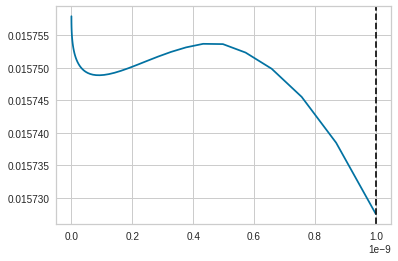

In [35]:
# select the alpha for lasso
from sklearn.linear_model import LassoCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection

# Load the regression dataset
X,y, test = Load_DataSet()


# Create a list of alphas to cross-validate against
alphas = np.logspace(10^(-5), 10^(-3), 100)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X, y)


(1458, 79) (1459, 79)


AlphaSelection(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f034a4c34d0>,
               model=None)

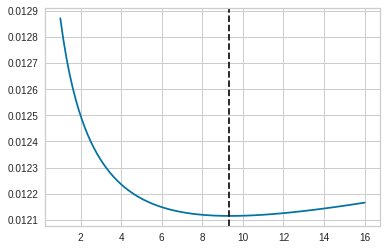

In [36]:
# find the alpha for ridge 
import numpy as np

from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ManualAlphaSelection

# Load the regression dataset
X,y, test = Load_DataSet()

# Create a list of alphas to cross-validate against
alphas = np.linspace(1,16, 100)

# Instantiate the visualizer
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X, y)



In [37]:
#if we couldn't run the model, we can just say: 
# for the simplity we just display the plots for ridge and lasso, 
# while running all models, and selecting alphas. 

# this is for ElasticNet 
# grid search hyperparameters for the elastic net
# from numpy import arange
# from pandas import read_csv
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedKFold
# from sklearn.linear_model import ElasticNet
# # load the dataset
# X,y, test = Load_DataSet()
# # define model
# model = ElasticNet()
# # define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define grid
# grid = dict()
# grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0]
# grid['l1_ratio'] = arange(0, 1, 0.01)
# # define search
# search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # perform the search
# results = search.fit(X, y)
# # summarize
# print('MAE: %.3f' % results.best_score_)
# print('Config: %s' % results.best_params_)

(1458, 79) (1459, 79)


KeyboardInterrupt: ignored

In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import  KFold, cross_val_score
from  sklearn.linear_model import  ElasticNetCV, LassoCV, RidgeCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from datetime import  datetime

kfolds = KFold(n_splits=15, shuffle=True, random_state=10)

# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X,y=y):
    return np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))


ridge = make_pipeline(RobustScaler(),
                      RidgeCV( cv=kfolds,))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, random_state=10, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, 
                                        cv=kfolds, random_state=10
                                        ))

svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =10)


lightgbm = LGBMRegressor(objective='regression',
                                       num_leaves=4,
                                       learning_rate=0.01,
                                       n_estimators=5000,
                                       max_bin=200,
                                       bagging_fraction=0.75,
                                       bagging_freq=5,
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )


xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006, random_state=10)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

print('============> Regression Scores')

rmse = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))

rmse = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))

rmse = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))

rmse = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))

rmse = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))

rmse = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()) )

rmse = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))

rmse = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
print('================================================= end profile\n\n')

============> Regression Scores
Kernel Ridge score: 0.1195 (0.0173)

Lasso score: 0.1199 (0.0171)

ElasticNet score: 0.1200 (0.0170)

SVR score: 0.1198 (0.0180)

SVR score: 0.1198 (0.0180)

Lightgbm score: 0.1206 (0.0175)

GradientBoosting score: 0.1231 (0.0162)

[01:19:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:19:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:19:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:19:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:19:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in f

## Train the model for the final result

- train the model with full dataset

In [61]:
# rmsle
print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
2021-04-21 01:20:55.836639 StackingCVRegressor
[01:21:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:21:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:22:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2021-04-21 01:22:52.708930 elasticnet
2021-04-21 01:22

## Save the Single Model Result for Submit 

In [85]:
# lasso model 
submissionLasso = pd.read_csv("./sample_submission.csv")
submissionLasso["SalePrice"] = np.floor(np.expm1(lasso_model_full_data.predict(X_sub)))
submissionLasso.to_csv("submission_lasso.csv",index = False)

# elastic net model 
submissionElasticNet = pd.read_csv("./sample_submission.csv")
submissionElasticNet["SalePrice"] = np.expm1(elastic_model_full_data.predict(X_sub))
submissionElasticNet.to_csv("submission_ElasticNet.csv",index = False)

#ridge mode 
submissionRidge = pd.read_csv("./sample_submission.csv")
submissionRidge["SalePrice"] = np.expm1(ridge_model_full_data.predict(X_sub))
submissionRidge.to_csv("submission_Ridge.csv",index = False)

# svr 
submissionSVR = pd.read_csv("./sample_submission.csv")
submissionSVR["SalePrice"] = np.expm1(svr_model_full_data.predict(X_sub))
submissionSVR.to_csv("submission_SVR.csv",index = False)

#gbr
submissionGBR = pd.read_csv("./sample_submission.csv")
submissionGBR["SalePrice"] = np.expm1(gbr_model_full_data.predict(X_sub))
submissionGBR.to_csv("submission_GBR.csv",index = False)

#xgb
submissionXGR = pd.read_csv("./sample_submission.csv")
submissionXGR["SalePrice"] = np.expm1(xgb_model_full_data.predict(X_sub))
submissionXGR.to_csv("submission_XGR.csv",index = False)

# lgb
submissionLGB = pd.read_csv("./sample_submission.csv")
submissionLGB["SalePrice"] = np.expm1(lgb_model_full_data.predict(X_sub))
submissionLGB.to_csv("submission_LGB.csv",index = False)

# stack
submissionStack = pd.read_csv("./sample_submission.csv")
submissionStack["SalePrice"] = np.expm1(stack_gen_model.predict(np.array(X_sub)))
submissionStack.to_csv("submission_Stack.csv",index = False)




## Mix Models


In [87]:


def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

# save result
submissionBlend1 = pd.read_csv("./sample_submission.csv")
submissionBlend1.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

submissionBlend1.to_csv("submission_blend1.csv",index=False) #0.139

RMSLE score on train data:
0.0772736806007777


In [88]:
#this is what we tried after running the OLS, and entered the coefficients for the parameters here. We get 0.03312 as the RMSLE
def blend_models_predict(X):
    return (-0.0319+(-0.1421 * svr_model_full_data.predict(X)) + \
            (0.6796 * gbr_model_full_data.predict(X)) + \
            (1.0587 * xgb_model_full_data.predict(X)) + \
            (-0.6654 * lgb_model_full_data.predict(X)) + \
            (0.0717 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

# save result
submissionBlend2 = pd.read_csv("./sample_submission.csv")
submissionBlend2.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

submissionBlend2.to_csv("submission_blend2.csv",index=False) #0.139


RMSLE score on train data:
0.03418263385056202


In [ ]:


elastic_predVal = elastic_model_full_data.predict(X)
lasso_predVal   = lasso_model_full_data.predict(X)
ridge_predVal   = ridge_model_full_data.predict(X)
svr_predVal     = svr_model_full_data.predict(X)
gbr_predVal     = gbr_model_full_data.predict(X)
xgb_predVal     = xgb_model_full_data.predict(X)
lgb_predVal     = lgb_model_full_data.predict(X)
stack_predVal   = stack_gen_model.predict(np.array(X))
MixDataSet = pd.DataFrame({"elastic":elastic_predVal.tolist(),
                        "lasso": lasso_predVal.tolist(),
                        "ridge": ridge_predVal.tolist(),
                        "svr": svr_predVal.tolist(),
                        "gbr":gbr_predVal.tolist(),
                        "xgb":xgb_predVal.tolist(),
                        "lgb":lgb_predVal.tolist(),
                        "stack":stack_predVal.tolist(),
                        "SalePrice":y.to_list()
                        })
MixDataSet.head()



,elastic,lasso,ridge,svr,gbr,xgb,lgb,stack,SalePrice
0,12.230745,12.231341,12.232791,12.248616,12.251000,12.235823,12.224619,12.243899,12.247699
1,12.183846,12.184787,12.181339,12.150947,12.089971,12.072273,12.074918,12.073992,12.109016
2,12.311721,12.311496,12.318058,12.323631,12.319688,12.283889,12.277665,12.326297,12.317171
3,11.978881,11.977017,11.978618,11.988970,11.857077,11.923270,11.961658,11.847834,11.849405
4,12.578977,12.579139,12.584439,12.601858,12.445777,12.551553,12.588127,12.525351,12.429220


In [ ]:
# split the df to constain x variables and y variable ( salesprice ) 
x_variables = MixDataSet[["elastic","lasso","ridge","svr","gbr","xgb","lgb","stack"]]
y_variables = MixDataSet["SalePrice"]

#run the regression 
import statsmodels.api as sm
X_train_lm = sm.add_constant(x_variables)

lr_1 = sm.OLS(y_variables, X_train_lm).fit()

lr_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 2.629e+04
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        01:37:05   Log-Likelihood:                 2902.5
No. Observations:                1458   AIC:                            -5787.
Df Residuals:                    1449   BIC:                            -5740.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0297      0.030     -0.983      0.326      -0.089       0.030
elastic       -0.4609      0.705     -0.654      0.513      -1.843       0.921
lasso          0.1782      0.721      0.247      0.805      -1.235       1.592
ridge          0.3428      0.169      2.032      0.042       0.012       0.674
svr           -0.1975      0.040     -4.880      0.000      -0.277      -0.118
gbr            0.6861      0.022     31.726      0.000       0.644       0.729
xgb            1.0595      0.039     27.181      0.000       0.983       1.136
lgb           -0.6769      0.033    -20.770      0.000      -0.741      -0.613
stack          0.0710      0.031      2.301      0.022       0.010       0.132
==============================================================================
Omnibus:                      822.988   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46581.443
Skew:                          -1.866   Prob(JB):                         0.00
Kurtosis:                      30.438   Cond. No.                     3.93e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the above summary, we can see that elastic and lasso models are not significant, as their p-values are greater than 0.5. Thus, we will drop these two models. By running the new OLS without elastic and lasso, we figure out that ridge is also insignificant, so we ditch it as well and then run the latest OLS model. 


In [ ]:
x_variables1 = MixDataSet[["svr","gbr","xgb","lgb","stack"]]
y_variables = MixDataSet["SalePrice"]

#run the regression 
import statsmodels.api as sm
X_train_lm1 = sm.add_constant(x_variables1)

lr_2 = sm.OLS(y_variables, X_train_lm1).fit()

lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 4.198e+04
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        01:49:53   Log-Likelihood:                 2899.6
No. Observations:                1458   AIC:                            -5787.
Df Residuals:                    1452   BIC:                            -5755.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0319      0.028     -1.120      0.263      -0.088       0.024
svr           -0.1421      0.016     -8.862      0.000      -0.174      -0.111
gbr            0.6796      0.021     31.849      0.000       0.638       0.721
xgb            1.0587      0.039     27.194      0.000       0.982       1.135
lgb           -0.6654      0.032    -20.770      0.000      -0.728      -0.603
stack          0.0717      0.031      2.342      0.019       0.012       0.132
==============================================================================
Omnibus:                      827.087   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46240.047
Skew:                          -1.884   Prob(JB):                         0.00
Kurtosis:                      30.330   Cond. No.                     1.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X.head()

,OverallQual,TotalSF,GrLivArea,YrBltAndRemod,YearBuilt,Total_sqr_footage,Total_Bathrooms,GarageCars,TotalBsmtSF,GarageArea,1stFlrSF,YearRemodAdd,ExterQual_TA,GarageYrBlt,FullBath,TotRmsAbvGrd,KitchenQual_TA,ExterQual_Gd,LotFrontage,2ndFlrSF,LotArea,Foundation_PConc,KitchenQual_Gd,BsmtQual_TA,FireplaceQu_None,hasfireplace,Fireplaces,Total_porch_sf,BsmtQual_Gd,OpenPorchSF,BsmtFinSF1,GarageFinish_Unf,BsmtUnfSF,HeatingQC_Ex,MSSubClass_60,GarageFinish_Fin,BsmtQual_Ex,OverallCond,GarageType_Attchd,MasVnrArea,Foundation_CBlock,BsmtFinType1_GLQ,Exterior2nd_VinylSd,GarageType_Detchd,WoodDeckSF,Exterior1st_VinylSd,HeatingQC_TA,LotShape_Reg,KitchenQual_Ex,MSZoning_RM
0,7,1454.079523,8.353543,4006,2003,1175.708875,3.527858,2.0,422.488510,548.0,5.939034,2003,0,2003.0,2,2.261968,0,1,18.144574,1025.651979,13.833054,1,1,0,1,0,0.000000,12.080309,1,12.080309,144.117862,0,29.991055,1,1,0,0,3.991517,1,19.433175,0,1,1,0,0.000000,1,0,1,0,0
1,6,600.123170,7.974693,3952,1976,187.954177,2.355448,2.0,593.888179,460.0,6.234991,1976,1,1976.0,2,1.996577,1,0,20.673626,0.000000,14.117918,0,0,0,0,1,0.903334,56.184223,1,0.000000,181.719186,0,44.135415,1,0,0,0,6.000033,1,0.000000,1,0,0,0,56.184223,0,0,1,0,0
2,7,1496.595112,8.408064,4003,2001,1156.956429,3.527858,2.0,450.079716,608.0,5.994336,2002,0,2001.0,2,1.996577,0,1,18.668048,1040.521060,14.476512,1,1,0,0,1,0.903334,9.901081,1,9.901081,110.441033,0,56.896536,1,1,0,0,3.991517,1,17.768840,0,1,1,0,0.000000,1,0,0,0,0
3,7,1289.359694,8.358662,3885,1915,972.300441,1.993440,3.0,378.854568,642.0,6.027705,1970,1,1998.0,1,2.137369,0,0,17.249652,904.477422,14.106196,0,1,1,0,1,0.903334,24.986827,0,8.966115,61.795315,1,64.808858,0,0,0,0,3.991517,0,0.000000,0,0,0,1,0.000000,0,0,0,0,0
4,8,1824.496012,8.669321,4000,2000,1415.810686,3.527858,3.0,545.309927,836.0,6.161222,2000,0,2000.0,2,2.373753,0,1,21.314284,1273.024863,15.022008,1,1,0,0,1,0.903334,56.517270,1,14.271568,136.624601,0,61.166379,1,1,0,0,3.991517,1,25.404164,0,1,1,0,42.245702,1,0,0,0,0
